In [1]:
#tenemos que agregar al sys path el directorio
import sys
sys.path.append("/home/arturo/Documents/MasterCD/TFM/codigo/otros_repos/Anomaly-Transformer_oficial")
import numpy as np 
import torch
import matplotlib.pyplot as plt 
import time
from torch import nn

import os
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import collections
import numbers
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle

from model.AnomalyTransformer import AnomalyTransformer


In [2]:

def s(sigma):
    sigma=torch.from_numpy(sigma)
    sigma = torch.sigmoid(sigma * 5) + 1e-5
    sigma = torch.pow(3, sigma) - 1
    return sigma.detach().numpy()

In [14]:
x=np.linspace(-10,10,1000)
y=s(x)

In [15]:
x

array([-10.        ,  -9.97997998,  -9.95995996,  -9.93993994,
        -9.91991992,  -9.8998999 ,  -9.87987988,  -9.85985986,
        -9.83983984,  -9.81981982,  -9.7997998 ,  -9.77977978,
        -9.75975976,  -9.73973974,  -9.71971972,  -9.6996997 ,
        -9.67967968,  -9.65965966,  -9.63963964,  -9.61961962,
        -9.5995996 ,  -9.57957958,  -9.55955956,  -9.53953954,
        -9.51951952,  -9.4994995 ,  -9.47947948,  -9.45945946,
        -9.43943944,  -9.41941942,  -9.3993994 ,  -9.37937938,
        -9.35935936,  -9.33933934,  -9.31931932,  -9.2992993 ,
        -9.27927928,  -9.25925926,  -9.23923924,  -9.21921922,
        -9.1991992 ,  -9.17917918,  -9.15915916,  -9.13913914,
        -9.11911912,  -9.0990991 ,  -9.07907908,  -9.05905906,
        -9.03903904,  -9.01901902,  -8.998999  ,  -8.97897898,
        -8.95895896,  -8.93893894,  -8.91891892,  -8.8988989 ,
        -8.87887888,  -8.85885886,  -8.83883884,  -8.81881882,
        -8.7987988 ,  -8.77877878,  -8.75875876,  -8.73

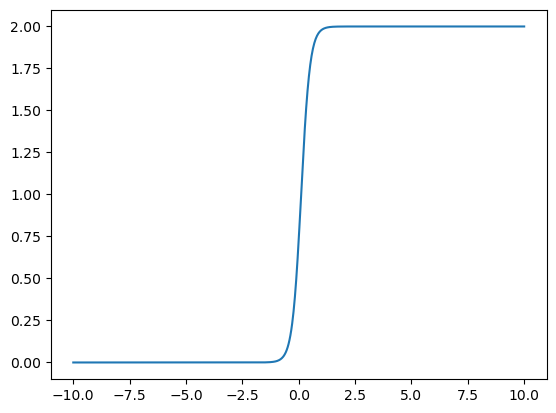

In [16]:
plt.plot(x,y)

## Cargar el modelo del repo Oficial:

In [3]:
#from torchsummary import summary
#from data_factory.data_loader import get_loader_segment


In [4]:
model=AnomalyTransformer(win_size=100, enc_in=25, c_out=25, e_layers=3, d_model=128, n_heads=4)

In [6]:
x=torch.randn(64,100,25)
enc_out, series, prior, sigmas=model(x)
print(enc_out.shape, len(series),series[0].shape, len(prior),prior[0].shape, len(sigmas),prior[0].shape)

torch.Size([64, 100, 25]) 3 torch.Size([64, 4, 100, 100]) 3 torch.Size([64, 4, 100, 100]) 3 torch.Size([64, 4, 100, 100])


In [16]:
array=series[:][1].detach().numpy().mean(axis=0)
array.shape

(4, 100, 100)

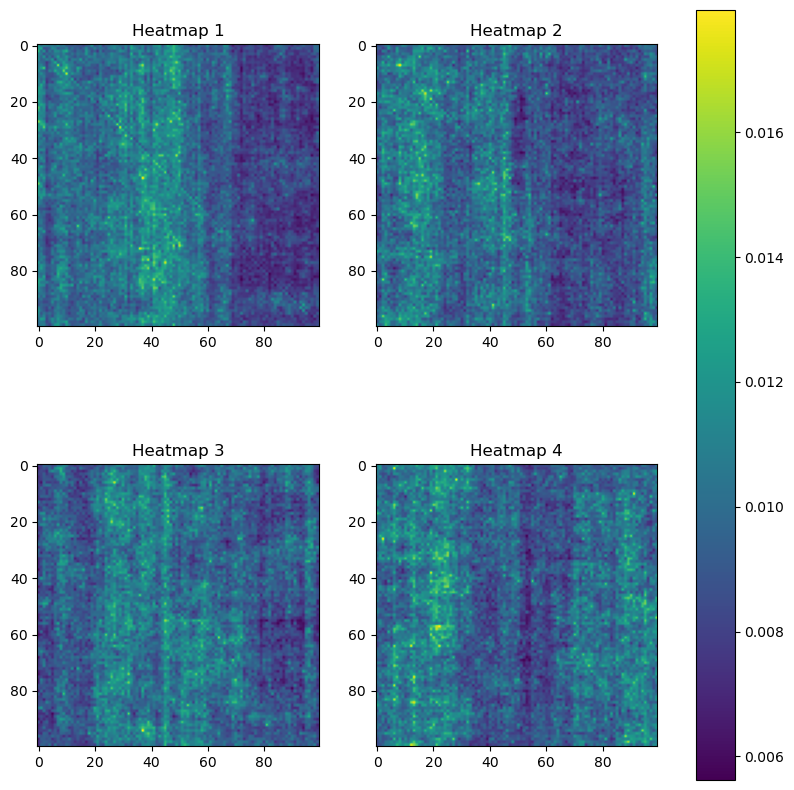

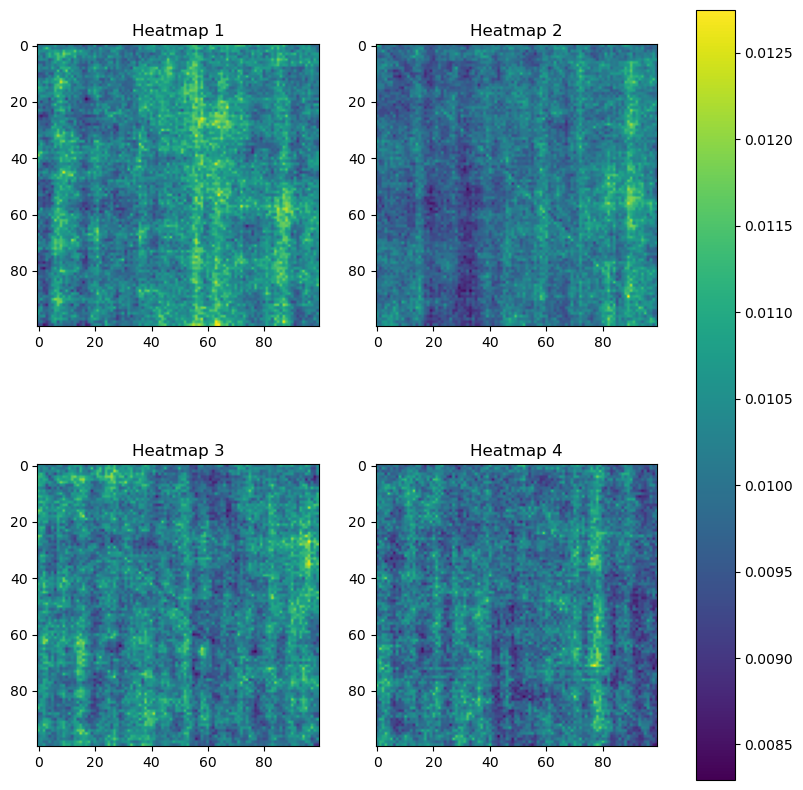

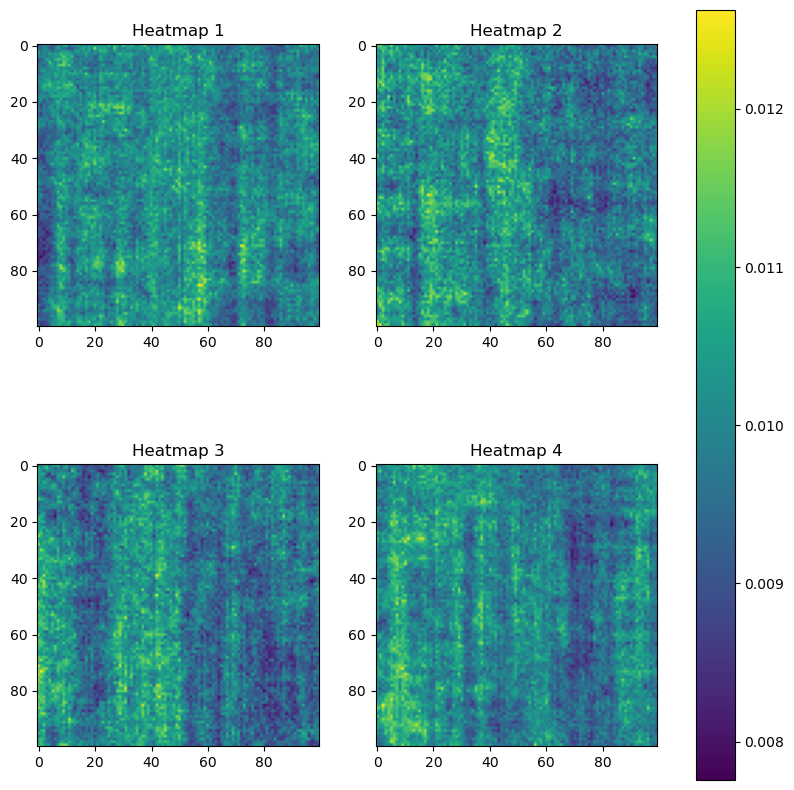

In [20]:
for j in [0,1,2]:
    array=series[j][:].detach().numpy().mean(axis=0)
    # Crear subplot de 2 filas y 2 columnas
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

    # Crear mapa de calor para cada gráfico en el subplot
    for i, ax in enumerate(axs.flat):
        heatmap = ax.imshow(array[i], cmap='viridis')
        ax.set_title(f'Heatmap {i+1}')

    # Agregar barra de color compartida
    fig.colorbar(heatmap, ax=axs.ravel().tolist())



In [7]:

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")


Total trainable parameters: 610213


In [53]:
a=list(model.parameters())

In [54]:
print(model)

AnomalyTransformer(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(25, 512, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0): EncoderLayer(
        (attention): AttentionLayer(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (inner_attention): AnomalyAttention(
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (query_projection): Linear(in_features=512, out_features=512, bias=True)
          (key_projection): Linear(in_features=512, out_features=512, bias=True)
          (value_projection): Linear(in_features=512, out_features=512, bias=True)
          (sigma_projection): Linear(in_features=512, out_features=8, bias=True)
          (out_projection): Linear(in_features=512, out_features=5

## Vamos a entrenarlo

In [13]:

class PSMSegLoader(object): ##y esto no deberia heredar de dataset?
    def __init__(self, data_path, win_size, step, mode="train"):
        self.mode = mode
        self.step = step
        self.win_size = win_size
        self.scaler = StandardScaler()
        data = pd.read_csv(data_path + '/train.csv')
        data = data.values[::100, 1:]

        data = np.nan_to_num(data)

        self.scaler.fit(data)
        data = self.scaler.transform(data)
        test_data = pd.read_csv(data_path + '/test.csv')

        test_data = test_data.values[:, 1:]
        test_data = np.nan_to_num(test_data)

        self.test = self.scaler.transform(test_data)

        self.train = data
        self.val = self.test

        self.test_labels = pd.read_csv(data_path + '/test_label.csv').values[:, 1:] ## y los labels de train ?

        print("test:", self.test.shape)
        print("train:", self.train.shape)

    def __len__(self):
        """
        Number of images in the object dataset.
        """
        if self.mode == "train":
            return (self.train.shape[0] - self.win_size) // self.step + 1
        elif (self.mode == 'val'):
            return (self.val.shape[0] - self.win_size) // self.step + 1
        elif (self.mode == 'test'):
            return (self.test.shape[0] - self.win_size) // self.step + 1
        else:
            return (self.test.shape[0] - self.win_size) // self.win_size + 1

    def __getitem__(self, index):
        index = index * self.step
        if self.mode == "train":
            return np.float32(self.train[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size])
        elif (self.mode == 'val'):
            return np.float32(self.val[index:index + self.win_size]), np.float32(self.test_labels[0:self.win_size])
        elif (self.mode == 'test'):
            return np.float32(self.test[index:index + self.win_size]), np.float32(self.test_labels[index:index + self.win_size])
        else:
            return np.float32(self.test[
                              index // self.step * self.win_size:index // self.step * self.win_size + self.win_size]), np.float32(
                self.test_labels[index // self.step * self.win_size:index // self.step * self.win_size + self.win_size])



def get_loader_segment(data_path, batch_size, win_size=100, step=100, mode='train', dataset='KDD'):
    # if (dataset == 'SMD'):
    #     dataset = SMDSegLoader(data_path, win_size, step, mode)
    # elif (dataset == 'MSL'):
    #     dataset = MSLSegLoader(data_path, win_size, 1, mode)
    # elif (dataset == 'SMAP'):
    #     dataset = SMAPSegLoader(data_path, win_size, 1, mode)
    # elif (dataset == 'PSM'):

    dataset = PSMSegLoader(data_path, win_size, 1, mode)

    shuffle = False
    if mode == 'train':
        shuffle = True

    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=0)
    return data_loader



class EarlyStopping:
    def __init__(self, patience=7, verbose=False, dataset_name='', delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.best_score2 = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_loss2_min = np.Inf
        self.delta = delta
        self.dataset = dataset_name

    def __call__(self, val_loss, val_loss2, model, path):
        score = -val_loss
        score2 = -val_loss2
        if self.best_score is None:
            self.best_score = score
            self.best_score2 = score2
            self.save_checkpoint(val_loss, val_loss2, model, path)
        elif score < self.best_score + self.delta or score2 < self.best_score2 + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_score2 = score2
            self.save_checkpoint(val_loss, val_loss2, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, val_loss2, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), os.path.join(path, str(self.dataset) + '_checkpoint.pth'))
        self.val_loss_min = val_loss
        self.val_loss2_min = val_loss2

In [14]:
datapath="/home/arturo/Documents/MasterCD/TFM/data_paper_AnomalyDiscrepancy/PSM/PSM"
train_loader = get_loader_segment(datapath, batch_size=64, win_size=100,mode='train',dataset="PSM")

test: (87841, 25)
train: (1325, 25)


In [15]:
win_size=100
model=AnomalyTransformer(win_size=win_size, enc_in=25, c_out=25, e_layers=3, d_model=128, n_heads=4)

In [16]:
def my_kl_loss(p, q):
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
    return torch.mean(torch.sum(res, dim=-1), dim=1)


def adjust_learning_rate(optimizer, epoch, lr_):
    lr_adjust = {epoch: lr_ * (0.5 ** ((epoch - 1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))


criterion = nn.MSELoss()
device="cpu"
lr=1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


train_steps = len(train_loader)
k=3
num_epochs=10
time_now = time.time()

for epoch in range(num_epochs):
    iter_count = 0
    loss1_list = []

    epoch_time = time.time()
    model.train()
    for i, (input_data, labels) in enumerate(train_loader):
        #print(input_data.shape)

        optimizer.zero_grad()
        iter_count += 1
        input = input_data.float().to(device)

        output, series, prior, sigmas = model(input_data)

        # calculate Association discrepancy
        series_loss = 0.0 ##con prior y series loss hace referencia al los por el que se entrena cada una de ellas. Y las calcula por separado porque tiene 
                            ##que incluir el detach
        prior_loss = 0.0
        for u in range(len(prior)):
            series_loss += (torch.mean(my_kl_loss(series[u], 
                                                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,win_size)).detach())) + 
                            torch.mean(my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,win_size)).detach(),
                                                    series[u])))
            
            prior_loss += (torch.mean(my_kl_loss(
                (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                        win_size)),
                series[u].detach())) + torch.mean(
                my_kl_loss(series[u].detach(), (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                win_size)))))
        series_loss = series_loss / len(prior)
        prior_loss = prior_loss / len(prior)

        rec_loss = criterion(output, input)

        loss1_list.append((rec_loss - k * series_loss).item())
        loss1 = rec_loss - k * series_loss
        loss2 = rec_loss + k * prior_loss

        if (i + 1) % 100 == 0:
            speed = (time.time() - time_now) / iter_count
            left_time = speed * ((num_epochs - epoch) * train_steps - i)
            print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            time_now = time.time()

        # Minimax strategy
        loss1.backward(retain_graph=True) ##importante porque sino se borran los gradientes de las variables
        loss2.backward()
        optimizer.step()

    print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
    train_loss = np.average(loss1_list)

    #vali_loss1, vali_loss2 = vali(test_loader)

    print(
        "Epoch: {0}, Steps: {1} | Train Loss: {2:.7f}  ".format(
            epoch + 1, train_steps, train_loss))

    adjust_learning_rate(optimizer, epoch + 1, lr)


Epoch: 1 cost time: 37.75924754142761
Epoch: 1, Steps: 20 | Train Loss: -32.6696898  
Updating learning rate to 0.001
Epoch: 2 cost time: 43.912489891052246
Epoch: 2, Steps: 20 | Train Loss: -43.4682339  
Updating learning rate to 0.0005
Epoch: 3 cost time: 51.06122612953186
Epoch: 3, Steps: 20 | Train Loss: -45.5923676  
Updating learning rate to 0.00025
Epoch: 4 cost time: 53.26595497131348
Epoch: 4, Steps: 20 | Train Loss: -46.0724958  
Updating learning rate to 0.000125
Epoch: 5 cost time: 52.78130054473877
Epoch: 5, Steps: 20 | Train Loss: -46.2756214  
Updating learning rate to 6.25e-05
Epoch: 6 cost time: 54.697075843811035
Epoch: 6, Steps: 20 | Train Loss: -46.3650751  
Updating learning rate to 3.125e-05
Epoch: 7 cost time: 53.70319390296936
Epoch: 7, Steps: 20 | Train Loss: -46.4114716  
Updating learning rate to 1.5625e-05
Epoch: 8 cost time: 58.912604331970215
Epoch: 8, Steps: 20 | Train Loss: -46.4175787  
Updating learning rate to 7.8125e-06
Epoch: 9 cost time: 55.3456859

In [18]:
len(series)

3

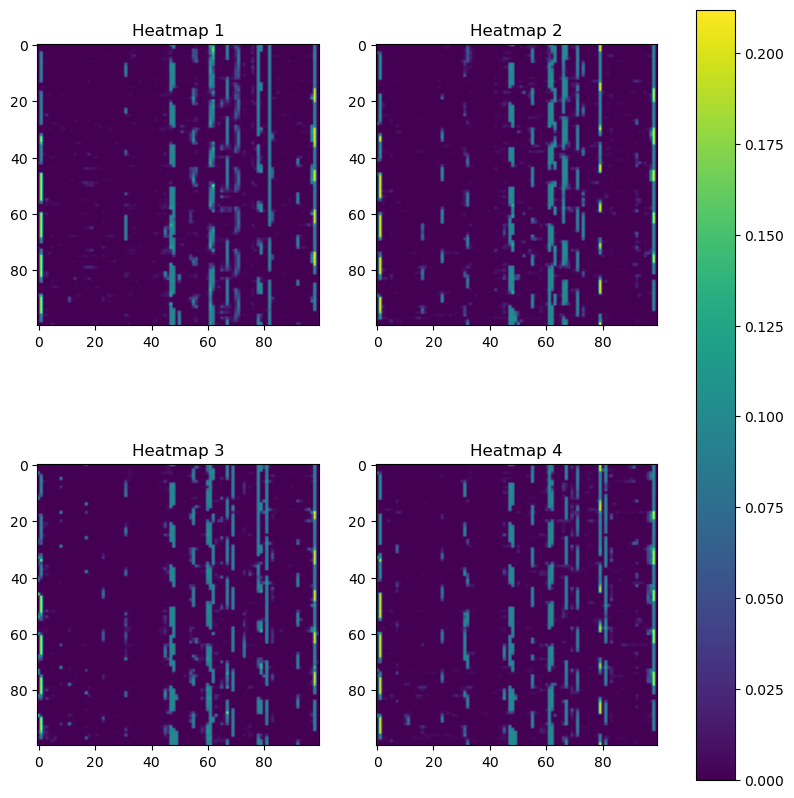

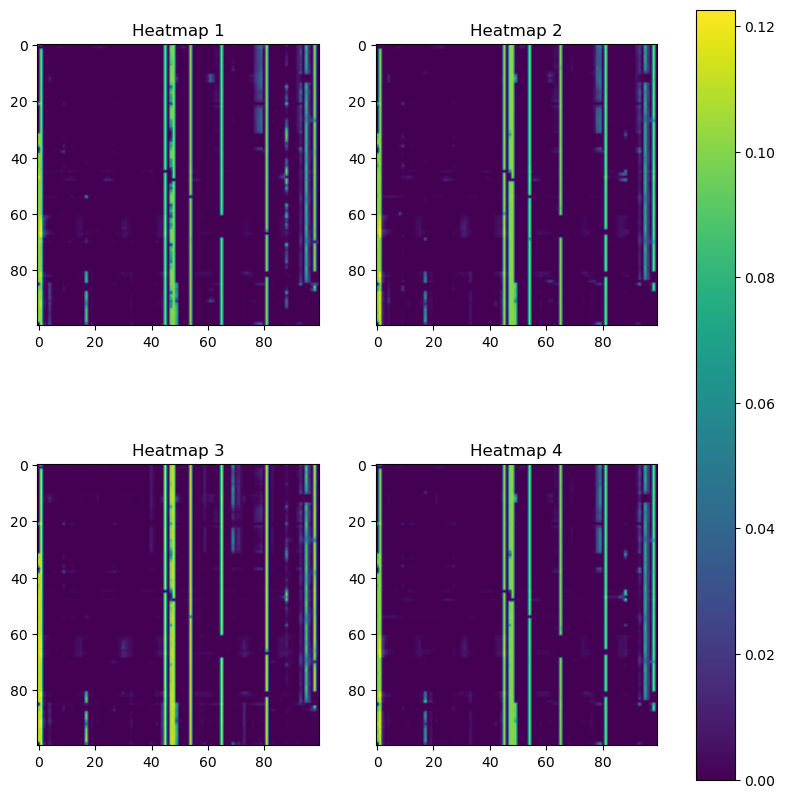

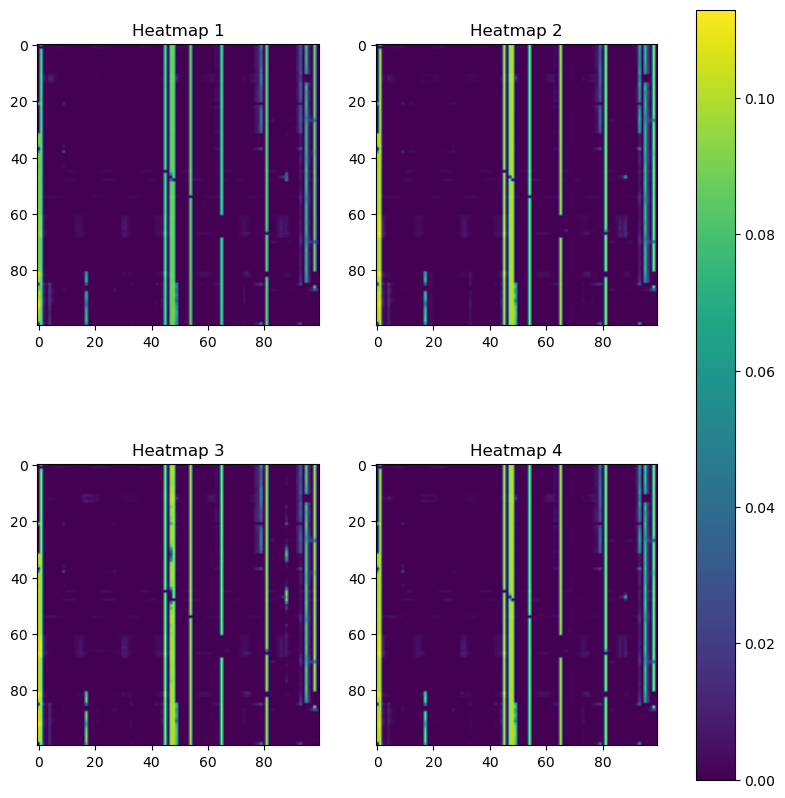

In [34]:
for j in [0,1,2]:
    array=series[j][:].detach().numpy().mean(axis=0)
    # Crear subplot de 2 filas y 2 columnas
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

    # Crear mapa de calor para cada gráfico en el subplot
    for i, ax in enumerate(axs.flat):
        heatmap = ax.imshow(array[i], cmap='viridis')
        ax.set_title(f'Heatmap {i+1}')

    # Agregar barra de color compartida
    fig.colorbar(heatmap, ax=axs.ravel().tolist())



In [31]:
x=next(iter(train_loader))[0]

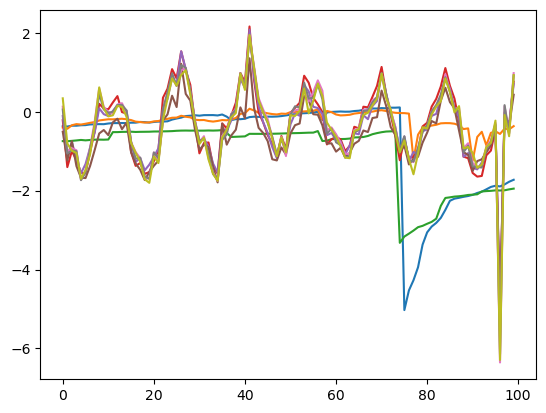

In [35]:
for i in [1,2,3,4,5,7,8,9,10]:
    plt.plot(x[1,:,i])